In [1]:
import pandas as pd

In [2]:
df = pd.read_feather('../datasets/processed/creditcard_standardized.feather')

X = df.iloc[:, :-1]
print(f"full size = {X.shape[0]}")
X = X.to_numpy()
print(f"{len(X[0])}")

# X_sample = X.sample(n=int(X.shape[0] / 20), random_state=13, replace=False).to_numpy()
# print(f"x_sample size = {X_sample.shape[0]}")

full size = 284807
30


In [3]:
from bnp_gmm import BayesianNonparametricMixture

alpha_init = [2, 10]
truncated_k = 50
bnp = BayesianNonparametricMixture(alpha_init, truncated_k)

In [13]:
bnp.train(num_iterations=30, x_train=X)

Now at iteration 0
active_clusters = 25
total_exp = -18.420778019918735
alpha_a = 52
alpha_b = 28
len(self.sticks) = 50
log_likelihood = -18662243.823677067
Now at iteration 1
active_clusters = 25
total_exp = -12.841955251881231
alpha_a = 52
alpha_b = 22
len(self.sticks) = 50
log_likelihood = -17615035.932509135
Now at iteration 2
active_clusters = 25
total_exp = -12.618470668897098
alpha_a = 52
alpha_b = 22
len(self.sticks) = 50
log_likelihood = -16795016.41872519
Now at iteration 3
active_clusters = 24
total_exp = -12.745723998694261
alpha_a = 52
alpha_b = 22
len(self.sticks) = 50
log_likelihood = -16174339.598729253
Now at iteration 4
active_clusters = 24
total_exp = -12.882973263851246
alpha_a = 52
alpha_b = 22
len(self.sticks) = 50
log_likelihood = -15722521.987091562
Now at iteration 5
active_clusters = 24
total_exp = -13.023509092757124
alpha_a = 52
alpha_b = 23
len(self.sticks) = 50
log_likelihood = -15430819.858079458
Now at iteration 6
active_clusters = 24
total_exp = -13.247

training with 50 truncated clusters for 30 iterations took ~23 hours and 38 minutes

In [6]:
import pickle

with open('../models/posteriors.pkl', 'rb') as f:
    saved_posteriors = pickle.load(f)
    niw_posteriors = saved_posteriors['niw_posteriors']
    alpha_posteriors = saved_posteriors['alpha_posteriors']
    sticks = saved_posteriors['sticks_list']
    log_likelihoods = saved_posteriors['log_likelihoods']
    active_clusters = saved_posteriors['active_clusters']

print(len(sticks))

50


In [4]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import numpy as np

plot the convergence of log_likelihood over the iterations

In [16]:
pio.renderers.default='notebook_connected'

In [17]:
iterations = np.arange(1, len(log_likelihoods) + 1)

df_convergence = pd.DataFrame({
    "Iteration" : iterations,
    "Log_likelihood" : log_likelihoods
})

fig = px.line(df_convergence, x="Iteration", y="Log_likelihood",
              markers=True, title="Log likelihoods over iterations")
fig.update_layout(template="plotly_white")
fig.show()

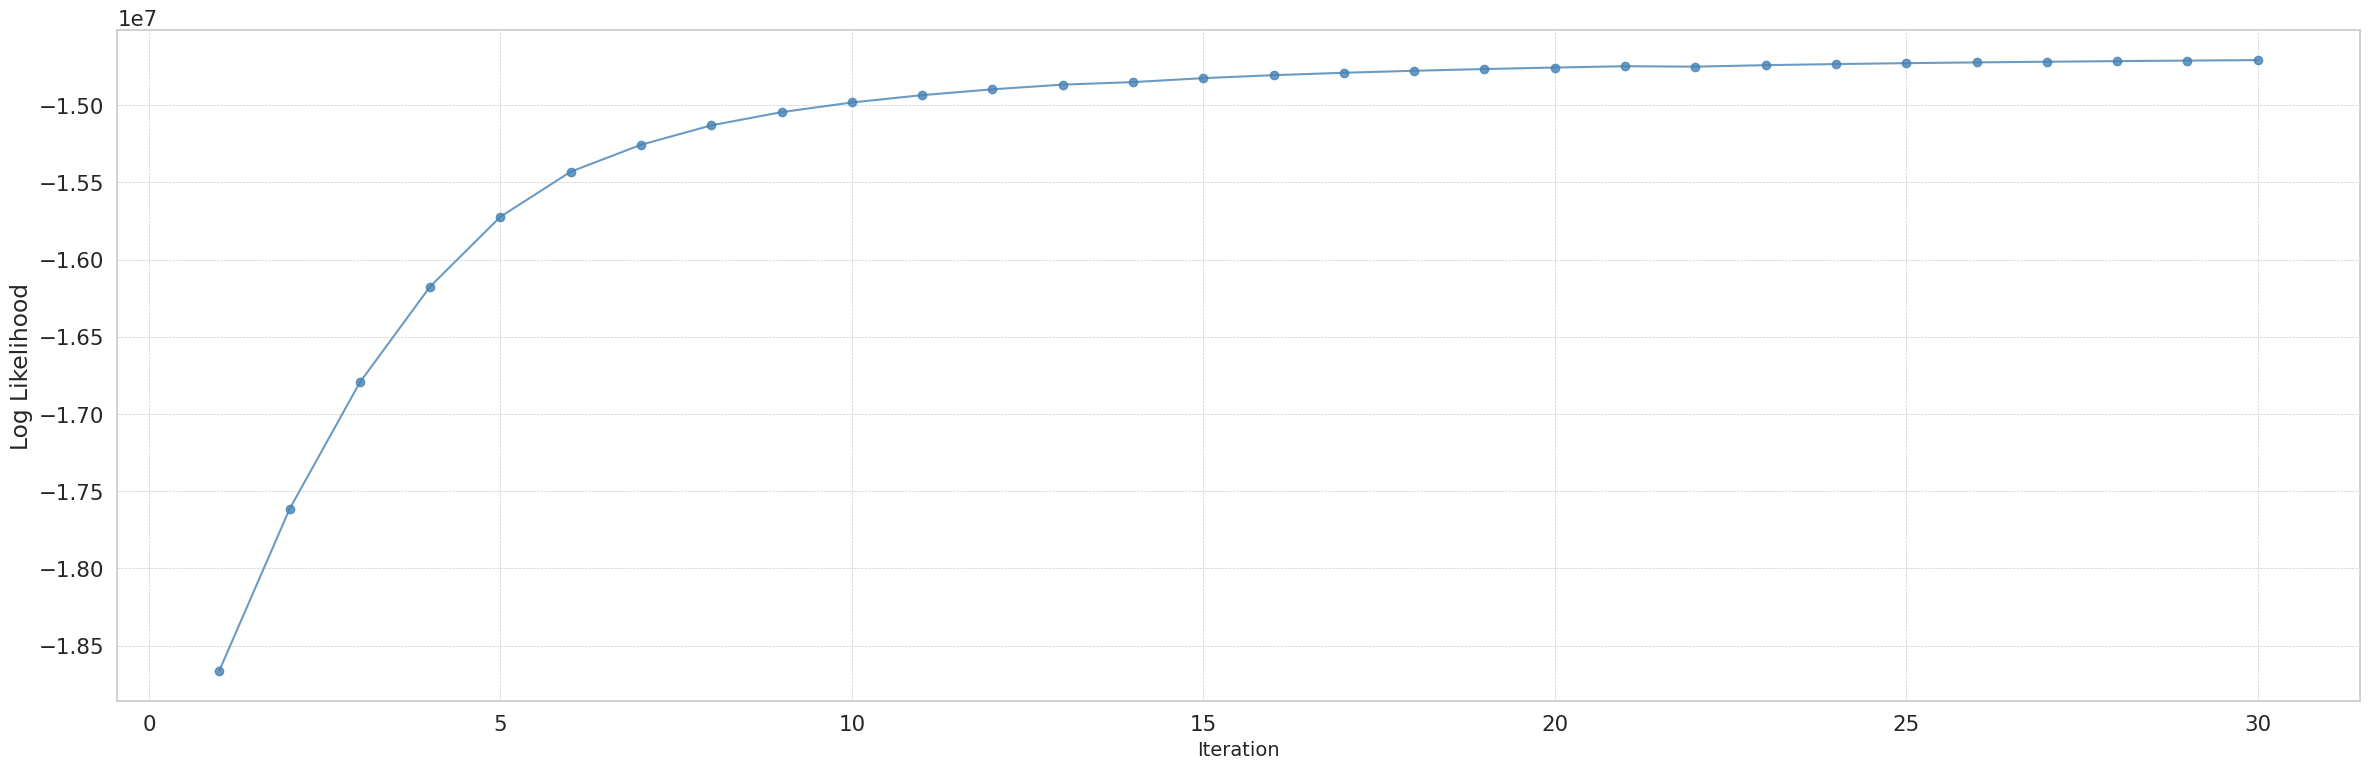

In [18]:
# plot and save fig with matplotlib
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid", font_scale=1.4)
plt.plot(iterations, log_likelihoods, marker='o', linestyle='-', color='steelblue', alpha=0.8)

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log Likelihood")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("../assets/Log_likelihoods.png")


significant improvements in the first 10 iterations, afterwards the log likelihood plateaus; maybe stop training after 20, just to be safe

In [19]:
mixing_weights = [stick.weight for stick in sticks]
clusters = np.arange(1, len(mixing_weights) + 1)

df_weights = pd.DataFrame({
    "Cluster": clusters,
    "Weight": mixing_weights
})

fig = px.bar(df_weights, x="Cluster", y="Weight",
            title="Mixture weights per cluster",
            labels={"Cluster" : "Cluster index", "Weight" : "Mixture weight"})

fig.update_layout(template="plotly_white")
fig.add_hline(y=0.002, line_dash="dash", line_color="orange", 
              annotation_text="Active clusters threshold")  # 0.002 because of rounding errors
fig.show()

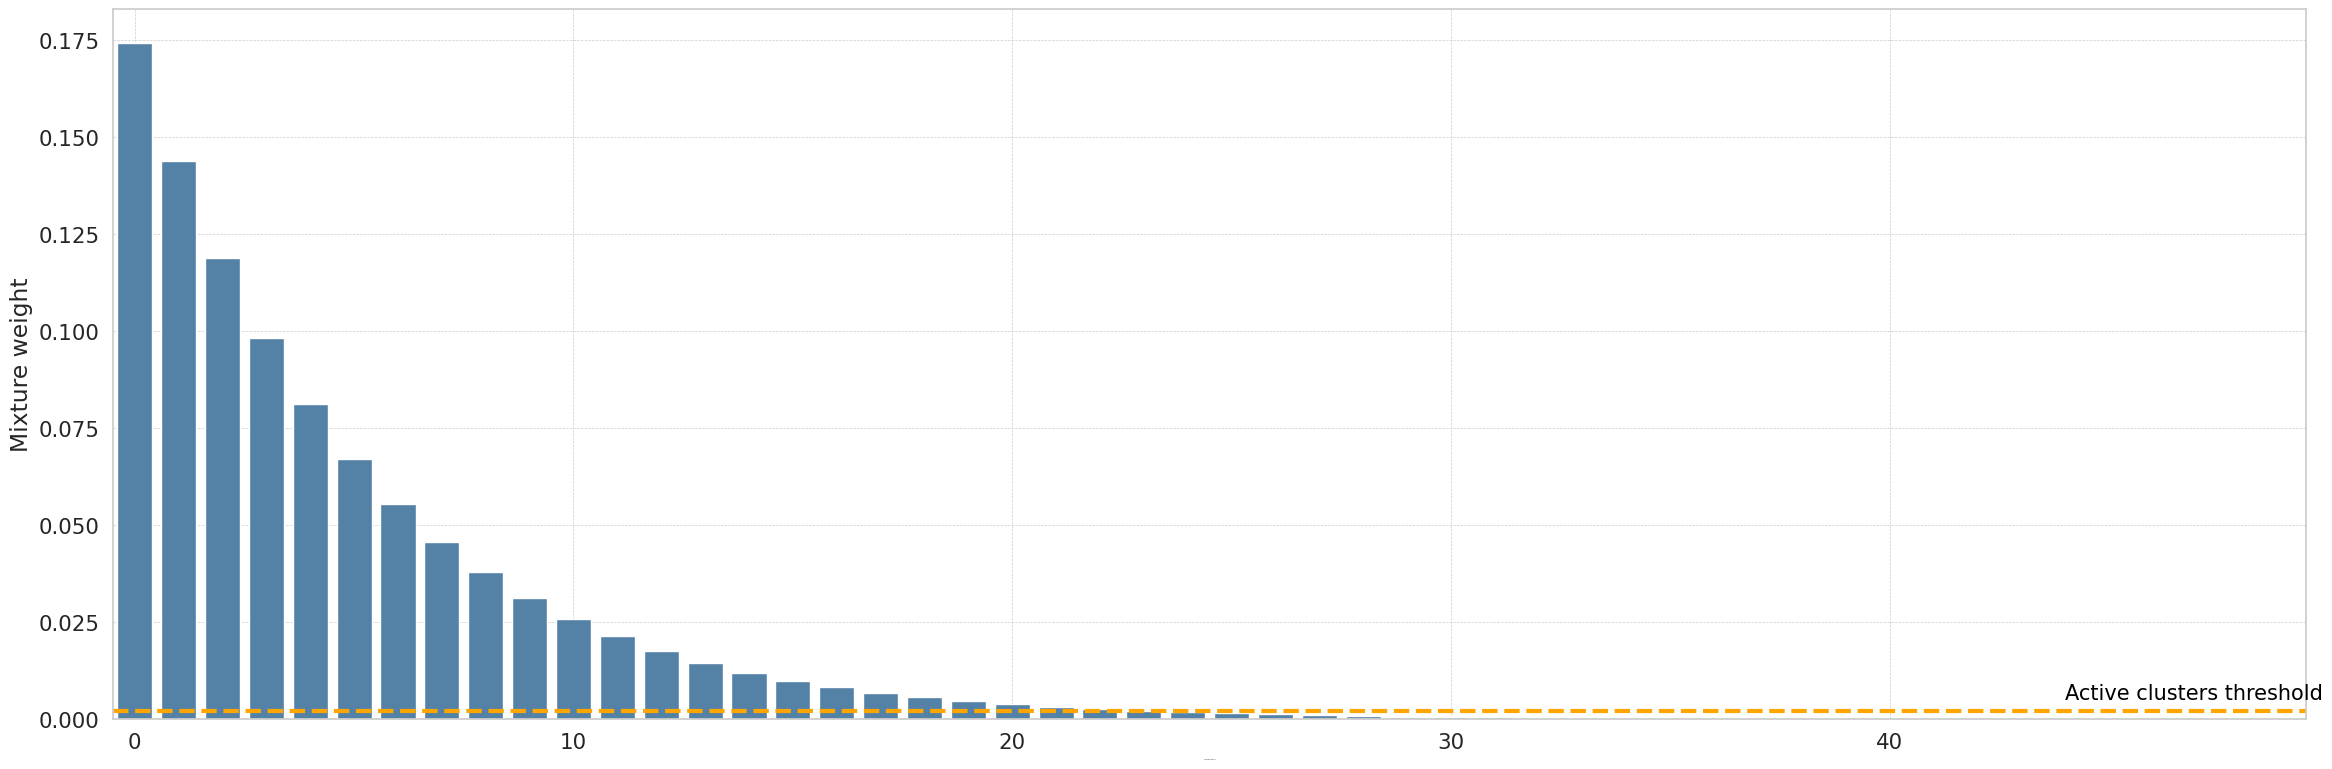

In [20]:
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid", font_scale=1.4)
sns.barplot(mixing_weights, color='steelblue')

plt.xlabel("Cluter index", fontsize=1.4)
plt.ylabel("Mixture weight")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.axhline(y=0.002, color='orange', linestyle='--', linewidth=3)
plt.text(x=len(mixing_weights) - 6, y=0.002 + 0.003, s='Active clusters threshold', color='black', fontsize=15)


plt.tight_layout()

plt.savefig("../assets/Clusters_weight.png")

In [85]:
print(f"Final number of active clusters {active_clusters}")

Final number of active clusters 24


K was truncated at 50, but the 'active' clusters (which had 99% of the total weight) were, in fact, only 24

In [21]:
print(f"Alpha_posteriors = {alpha_posteriors}")

Alpha_posteriors = [52 25]


alpha ~ Gamma(a, b), and E[alpha] = a/b <br> I conditioned it to be [2, 10] which encourages very few clusters to form (expected value = 2/10 ~ 0.2) <br> The aposteriori parameters, however, favour fragmented clusters [52, 25], with less density (expected value = 52/25 ~ 2), meaning that there are some regions in the data-space that are different than the others

In [6]:
df = pd.read_feather('../datasets/processed/creditcard_standardized.feather')
anomalous_instances = df.index[df['Class'] == 1].tolist()
print(len(anomalous_instances))

492


In [8]:
# Version I: flag as anomalous the intances with the lowest 1% of log-likelihood

from utils import student_t_pdf, weight_posterior, instance_log_likelihood

truncated_k = 50
mixing_weights = np.zeros(truncated_k)

print(f"len(sticks) = {len(sticks)}")

for k in range(truncated_k):
    mixing_weights[k] = weight_posterior(k, sticks)

cluster_probs = np.array(instance_log_likelihood(X[1:200], truncated_k, niw_posteriors, mixing_weights))
with open('../models/instance_log_likelihood.pkl', 'wb') as f:
    pickle.dump(cluster_probs, f)

"""
with open('../models/instance_log_likelihood.pkl', 'rb') as f:
    cluster_probs = pickle.load(f)
"""

len(sticks) = 50
log pdf for instance 0 = 8.328395580469585e-157
log pdf for instance 1 = 2.7852933001768433e-172
log pdf for instance 2 = 3.801255861962119e-163
log pdf for instance 3 = 4.353937828065355e-159
log pdf for instance 4 = 1.158858123963172e-156
log pdf for instance 5 = 1.6741067717696288e-157
log pdf for instance 6 = 4.146376358692676e-177
log pdf for instance 7 = 9.393627872641198e-162
log pdf for instance 8 = 8.098436303078332e-158
log pdf for instance 9 = 1.6235051793698573e-160
log pdf for instance 10 = 5.3940638377988625e-163
log pdf for instance 11 = 8.437466980638815e-161
log pdf for instance 12 = 4.627974865749931e-158
log pdf for instance 13 = 4.70821331542365e-167
log pdf for instance 14 = 6.169641013128571e-162
log pdf for instance 15 = 4.970443678446359e-157
log pdf for instance 16 = 2.3615569428059444e-158
log pdf for instance 17 = 2.1054369057642206e-185
log pdf for instance 18 = 1.6769660389818512e-159
log pdf for instance 19 = 1.7914931296989906e-162
log pd

"\nwith open('../models/instance_log_likelihood.pkl', 'rb') as f:\n    cluster_probs = pickle.load(f)\n"

In [ ]:

print(mixing_weights)
mixing_weights = mixing_weights[:, np.newaxis]  # (K, 1)
weighted_probs = cluster_probs * mixing_weights

print(weighted_probs)

anomaly_scores = np.log(np.sum(weighted_probs, axis=0) + 1e-12) # sum over clusters
print(anomaly_scores)

print(X[1:5])

threshold = np.percentile(anomaly_scores, 1)
anomalies = X[anomaly_scores < threshold]
print(len(anomalies))


[[[1.74213576e-01]]

 [[1.43927712e-01]]

 [[1.18905294e-01]]

 [[9.82315741e-02]]

 [[8.11507813e-02]]

 [[6.70384914e-02]]

 [[5.53788002e-02]]

 [[4.57454632e-02]]

 [[3.77863138e-02]]

 [[3.12103892e-02]]

 [[2.57772928e-02]]

 [[2.12884071e-02]]

 [[1.75796320e-02]]

 [[1.45153865e-02]]

 [[1.19836516e-02]]

 [[9.89187566e-03]]

 [[8.16359094e-03]]

 [[6.73561817e-03]]

 [[5.55575698e-03]]

 [[4.58087765e-03]]

 [[3.77534452e-03]]

 [[3.10971330e-03]]

 [[2.55965483e-03]]

 [[2.10506580e-03]]

 [[1.72933396e-03]]

 [[1.41873108e-03]]

 [[1.16191131e-03]]

 [[9.49496764e-04]]

 [[7.73735167e-04]]

 [[6.28217124e-04]]

 [[5.07642820e-04]]

 [[4.07629869e-04]]

 [[3.24555717e-04]]

 [[2.55429746e-04]]

 [[1.97792105e-04]]

 [[1.49639234e-04]]

 [[1.09381053e-04]]

 [[7.58449835e-05]]

 [[4.83599432e-05]]

 [[2.69560201e-05]]

 [[1.24677807e-05]]

 [[5.24497297e-06]]

 [[2.66519277e-06]]

 [[1.61456280e-06]]

 [[1.03667529e-06]]

 [[6.80745956e-07]]

 [[4.51927552e-07]]

 [[3.01772500

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# Version II: flag as anomalous the instances from the non-active clusters